# Switchable dual-band generation of femtosecond pulses in a mode-locked Erbium-doped fiber laser based on monolayer graphene
### *Sergio Castrillon. S. , Esteban Marulanda. A. , David Steinberg , Andrés B. Pérez , Javier F. Botia, Ana M. Cárdenas, Lucia A. M. Saito,  EA Thoroh de Souza, And Juan D.Zapata*



In [1]:
# Libraries

In [2]:
import matplotlib
from ipywidgets import interact,widgets
import numpy as np
import matplotlib.pylab as plt
import celluloid as cell  #animations
import pandas as pd
import os
from scipy.interpolate import CubicSpline
import math




def fourierT(f):

    return (np.fft.fftshift(np.fft.fft(np.fft.fftshift(f))))


def fourierI(f):

    return (np.fft.fftshift(np.fft.ifft(np.fft.fftshift(f))))

def metric(a1,a2,t):

    return np.abs((np.trapz(np.abs(a1)**2,t)-np.trapz(np.abs(a2)**2,t)))/np.trapz(np.abs(a2)**2,t)

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

# Cross sections profiles

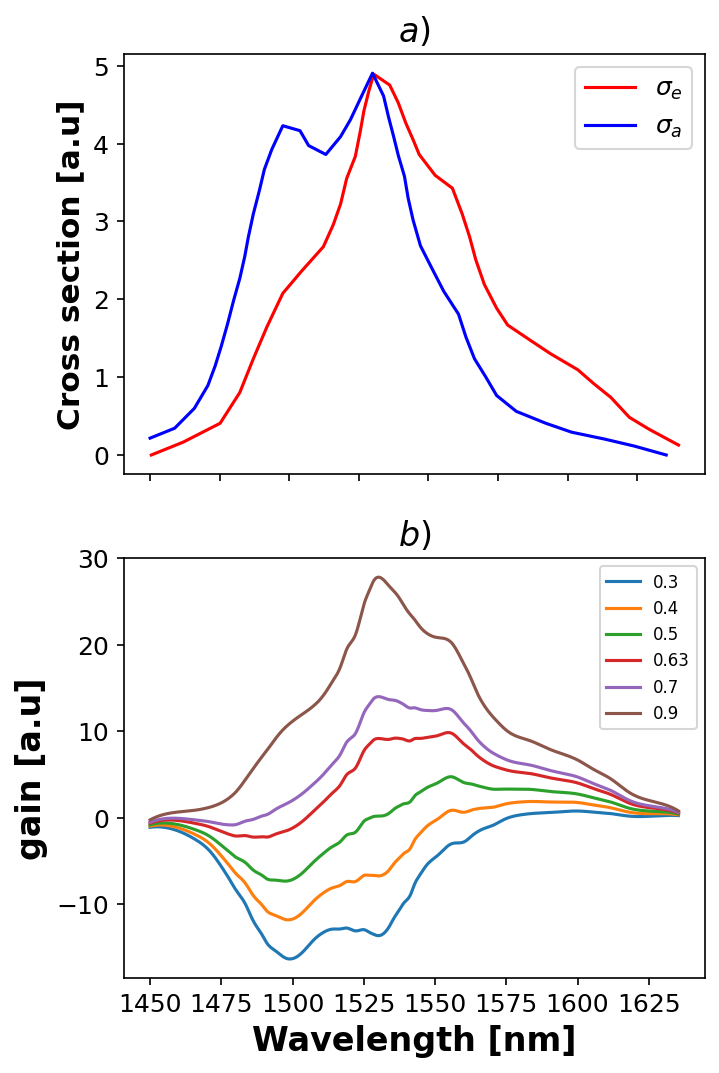

In [3]:
T = 175 
nt = 2**12
dt = T/nt
t = np.linspace(-T/2,T/2,nt)
dw= 2*np.pi/(nt*dt)
w = np.array([j*dw for j in range(-int(nt/2), int(nt/2))])
luz = 299792458


emis = np.loadtxt('Emision.txt',delimiter=';')
ab = np.loadtxt('Absorcion.txt',delimiter=';')


emis_y = emis[:,1]
emis_x = emis[:,0]
we = np.sort((2*np.pi*luz/(emis_x*1e-9)*1e-12))
midwe = (max(we)+min(we))/2
we = we-midwe


abs_y = ab[:,1]
abs_x = ab[:,0] #np.linspace(1400,1650,len(emis_y))
wa = np.sort((2*np.pi*luz/(abs_x*1e-9)*1e-12))
midwa =(max(wa)+min(wa))/2
wa = wa-midwa

cse1 = CubicSpline(emis_x,emis_y)
emis_xdata = np.linspace(min(abs_x),max(emis_x),nt)
Y_emis = cse1(emis_xdata)


# Interpolación para la simulación

cse = CubicSpline(we,emis_y)
csa = CubicSpline(wa,abs_y)

csa1 =CubicSpline(abs_x,abs_y)
abs_xdata = np.linspace(min(abs_x),max(abs_x),nt)
Y_abs = csa1(abs_xdata)


def gg1(G):

  return ((G)*cse1(emis_xdata)-(1-G)*csa1(abs_xdata))*7

f=plt.figure(figsize=(5,8),dpi=150)



plt.subplot(211)
plt.plot(emis_x,emis_y,'r',label='$\sigma_e$')
plt.gca().set_xticklabels([]) 
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.plot(abs_x,abs_y,'b',label='$\sigma_a$')
plt.title('$a)$',fontsize=16,fontweight='bold')
#plt.xlabel('Wavelength [nm]',fontsize=16,fontweight='bold')
plt.ylabel('Cross section [a.u]',fontsize=15,fontweight='bold',x=-5)
plt.legend(fontsize=12)


D= [0.3,0.4,0.5,0.63,0.7,0.9]
plt.subplot(212)


for i in D:
    
    plt.plot(abs_xdata,gg1(i),label=str(round(i,3)))
    
    
plt.xlabel('Wavelength [nm]',fontsize=16,fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('gain [a.u]',fontsize=16,fontweight='bold',x=-0.1)
plt.title('$b)$',fontsize=16,fontweight='bold')
plt.legend(fontsize=8)


#plt.savefig('cross.svg', format='svg', dpi=1200)

# Propagation solution

In [4]:
# EDF propagation

def fibraerbio(u0,dt,dz2,nz2,PL,Tr,loss,D2,gamma2,G,GG):
    
    V = w # Frequency THz
    
    gainn = ((G)*cse1(emis_xdata)-(1-G)*csa1(emis_xdata))

    gain_fit = CubicSpline(V,gainn)

    V = np.fft.fftshift(V)

    gain = gain_fit(V)*GG
    
    gahno = gain*np.exp(-np.trapz(np.abs(u0)**2,t)/(PL*Tr))

    halfstep1 =-loss+gahno-1j*D2/2*(1j*V)**2
    #gahno-loss+gahno/omega**2*(1j*V)**2-1j*D2/2*(1j*V)**2

    halfstep = np.exp(halfstep1*dz2/2)

    u1 = u0

    for iz in range(1,nz2):

        ufft1 = np.fft.fft(u1)
        uhalf1 = np.fft.ifft(halfstep*ufft1) # paso 1
        as1 = (np.abs(u1)**2)
        uv1 = uhalf1*np.exp((1j*gamma2*as1)*dz2) # paso 2
        uv1 = np.fft.fft(uv1)
        ufft1 = halfstep*uv1
        uv1 = np.fft.ifft(ufft1)
        u1 = uv1

    return u1


#SMF propagation
def fibrasmf(u0,dt,dz1,nz1,D1,gamma1,alpha):
    
    V = w
    V = np.fft.fftshift(V)
    halfstep1 = - alpha - 1j*(D1/2)*((1j*V)**2)
    halfstep = np.exp(halfstep1*dz1/2)
    u1 = u0
    

    for iz in range(1,nz1):
        

        ufft1 = np.fft.fft(u1)
        uhalf1 = np.fft.ifft(halfstep*ufft1)
        as1 =  (np.abs(u1)**2)
        uv1 = uhalf1*np.exp((1j*gamma1*as1)*dz1)
        uv1 = np.fft.fft(uv1)
        ufft1 = halfstep*uv1
        uv1 = np.fft.ifft(ufft1)
        u1 = uv1;
        

    return u1


def grafeno(u,q0,qns,Ea,ta1):
    

    return (1-(qns+q0/(1+np.abs(u)**2/(Ea/ta1))))*u



# SIMULATION PARAMETERS.

Text(0.5, 0, '$\\omega$')

<Figure size 1000x300 with 0 Axes>

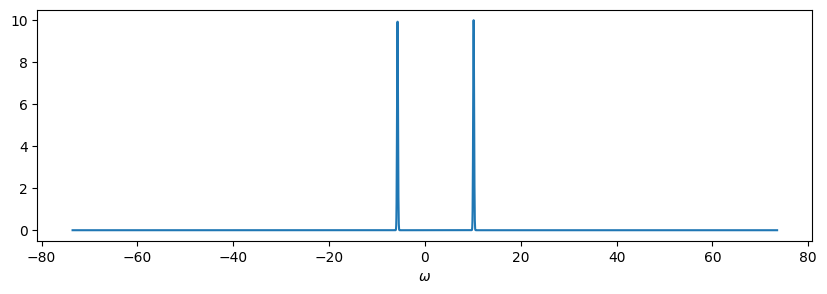

In [5]:
luz = 299792458
wl = 1550
P0 = 100
A = np.random.uniform(low=1e-4, high=np.sqrt(P0), size=nt) # Seed
V = np.array([j*dw for j in range(-int(nt/2), int(nt/2))]) # Frequency THz


f=plt.figure(figsize=(10,3))



wk=(V+midwa)*1e12
WL=np.sort((2*np.pi*luz)/wk)*1e9


f=plt.figure(figsize=(10,3))
wl1 = 1550e-9
wl2 = 1530e-9
sigma = 0.1
w_new=(V+midwa)*1e12

w01  = (((2*np.pi*luz)/wl1)-midwa*1e12)
w02 = (((2*np.pi*luz)/wl2)-midwa*1e12)
A = 1

y1 = np.sqrt(P0)*np.exp(-(V+w01*1e-12)**2/(2*sigma**2))*A*1
y2 = np.sqrt(P0)*np.exp(-(V+w02*1e-12)**2/(2*sigma**2))*A
A = fourierI(y1+y2)
plt.plot(V,y1+y2)
plt.xlabel('$\omega$')

In [6]:
# PARAMETROS DA FIBRA SMF
z1 = 7.405 # Longitud de la fibra
nz1 = 100  # Número de pasos a integrar
dz1 = z1/nz1
loss = 2*1e-3 # dB/m
alpha = np.log(10.**(loss/10))   #attenuation coefficient 1/m
D11 = 6.1 # ps/(nm*km)
D1 = -(D11*wl**2/(2*np.pi*luz))  #% beta2 (ps^2/m)
gamma1 = 1.6*1e-3 # Parametro de nolinealidad

mult = 1
#% PARAMETROS DA FIBRA DE ERBIO
z2 = np.ones(mult)*0.335
nz2 = 100
dz2 = z2/nz2
n = 1.5
Tr = ((((z1+z2)*n)/luz))*1e12  # round trip
loss = 0
N = [0.63]*mult #;N
GG = [7]*mult
factor = 0.965*1e-3/(85*1e-3)
PL = mult*[85*factor*1e-3] #0.538*1e-3 #; % potencia de saturacion
#omega = 3.75 #5   #2*np.pi*3.75
#OK = Tr*PL
D21 = -22.75  #; % parametro de dispersão (GVD)
D2 = [-0.20]#-(D21*wl**2/(2*np.pi*luz))  #% beta2 (ps^2/m)

gamma2 = 5*1e-3 # Parametro de nolinealidad


# %PARAMETROS DEL ABSORBEDOR SATURABLE
Ea = 0.53*1e6*1e4*80e-12
alphas= 0.659
alphans= 0.032
 #np.linspace(1,100,20) #; % energia de saturacion (pJ)
tal = 1 #; % tiempo de recuperacion (ps)
voltas = 200 #; % numero de voltas






In [7]:
finF=[]
cond = []

# nn=np.linspace(0.99,1,1)
for l in range(len(N)):
    

    u=np.zeros((voltas,nt),dtype=complex)
    
    u[0,:] = A

    for ii in range(1,voltas):
        
        
        u[ii,:] = fibrasmf(u[ii-1,:],dt,dz1,nz1,D1,gamma1,alpha)        
        u[ii,:] = fibraerbio((u[ii,:]),dt,dz2[l],nz2,PL[l],Tr[l],loss,D2[l],gamma2,N[l],GG[l])        
        u[ii,:] = grafeno(u[ii,:],alphas,alphans,Ea,tal)*0.99

        #cond.append(metric(u[ii,:],u[ii-1],t))

    yf=np.abs(fourierT(u[3,:]))**2
    finF.append(yf/np.amax(yf))

    yf=np.abs(fourierT(u[50,:]))**2
    finF.append(yf/np.amax(yf))

    yf=np.abs(fourierT(u[150,:]))**2
    finF.append(yf/np.amax(yf))

    yf=np.abs(fourierT(u[-1,:]))**2
    finF.append(yf/np.amax(yf))

   



# Time profile

Text(0, 0.5, '$Normalized$ $Power$')

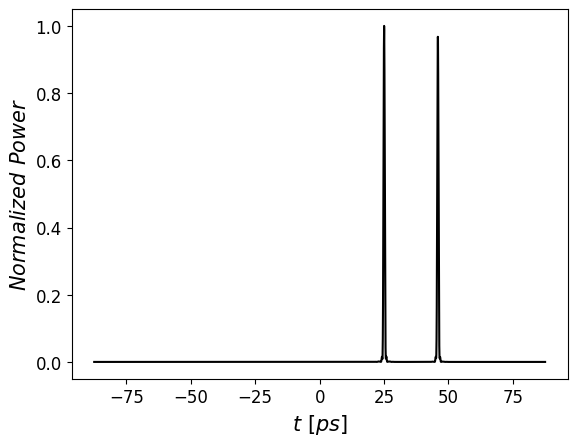

In [8]:
plt.plot(t,np.abs(u[-1,:])**2/np.max(np.abs(u[-1,:])**2),'k')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('$t$ $[ps]$',fontsize = 15, fontweight='bold')
plt.ylabel('$Normalized$ $Power$',fontsize = 15, fontweight='bold')
#plt.xlim(20,50)

Text(0.5, 0, '$\\lambda$ $[nm]$')

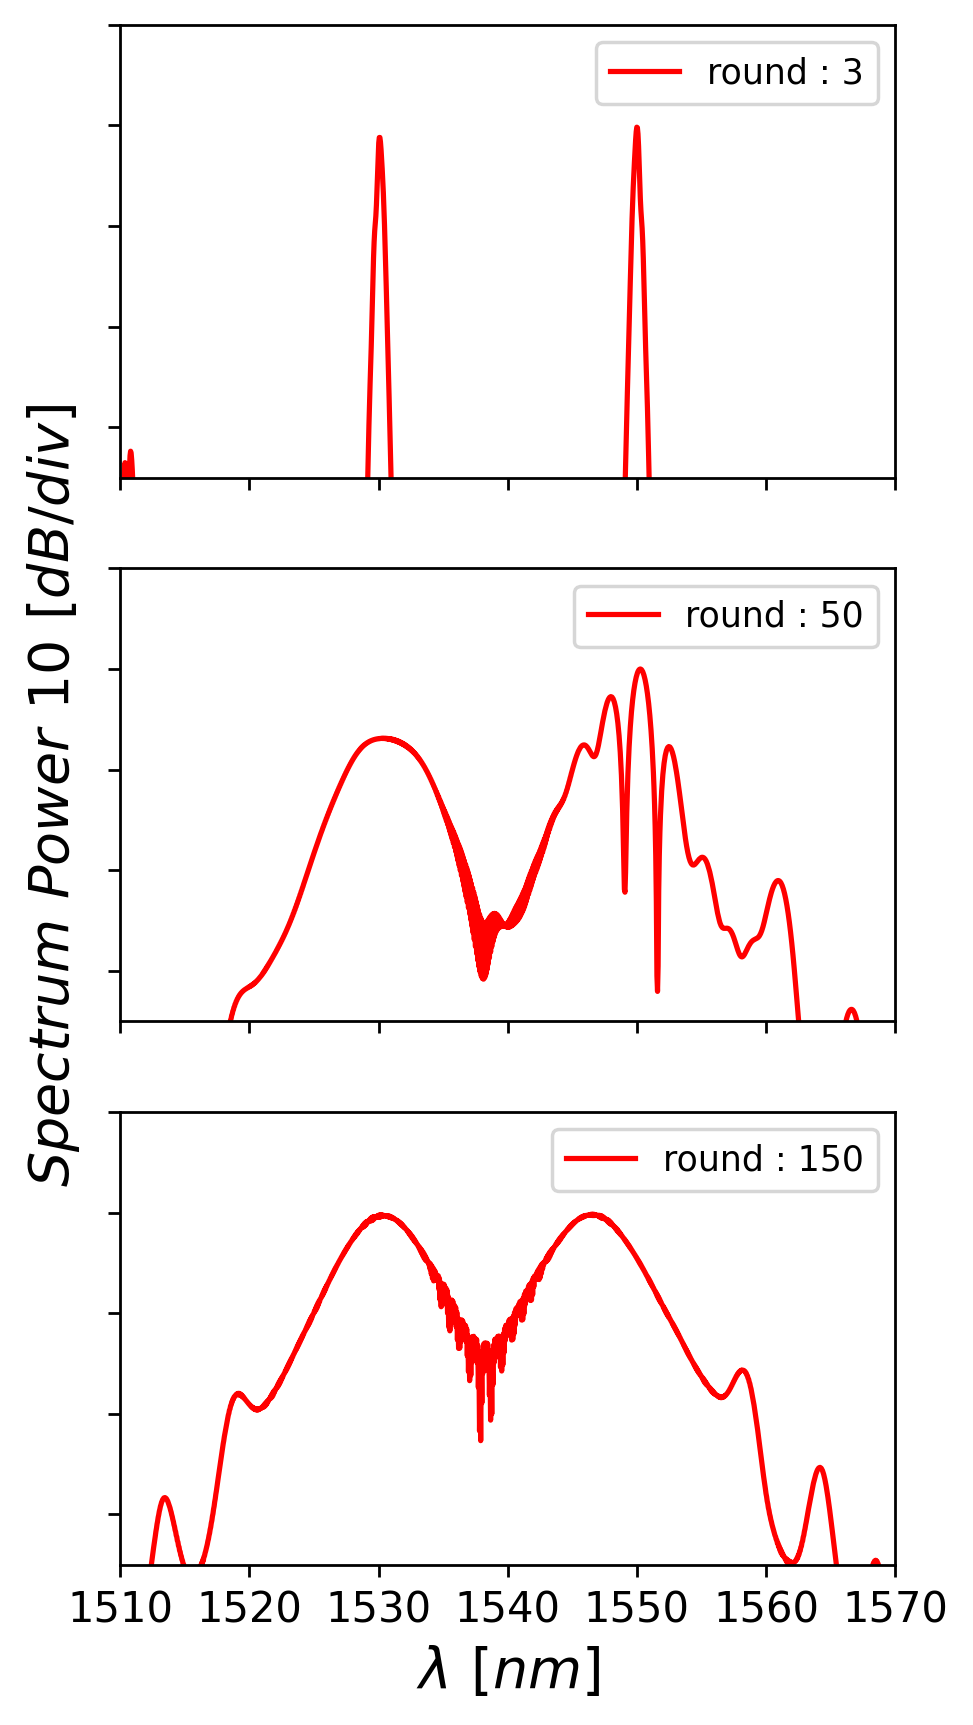

In [9]:
f=plt.figure(figsize=(4,8),dpi=250)
w = np.array([j*dw for j in range(-int(nt/2), int(nt/2))])
w_new=(w+midwa)*1e12
WL=np.sort((2*np.pi*luz)/w_new)


c=0
k=1
colors = ['3','50','150']
#labels = ['Erbium Dispersion',D2[1]/D2[0]*100-100,D2[2]/D2[0]*100-100] 



for j,yf in enumerate(finF): #[k:(k+1)]:
    
    
    yy = 10*np.log10(yf)
    #yy[yy<-30]=-33.5+10*np.random.rand(len(yy[yy<-30]))
    ww = 3
    y_new =  moving_average(yy, ww)
    x_new =  moving_average(WL*1e9,ww)
    if j<3:
        plt.subplot(3,1,j+1)
        plt.plot(x_new,y_new,'r',label='round : '+colors[j])
        plt.xlim(1510,1570)
        plt.ylim(-35,10)
        plt.gca().set_yticklabels([])
        plt.xticks(fontsize=12)
        plt.legend(loc = 'upper right')

        plt.yticks(fontsize=12)
    
    if j<2:
        plt.gca().set_xticklabels([])
        # plt.plot(1530*np.ones(len(WL)),yy)
    # plt.plot(1550*np.ones(len(WL)),yy)
    # plt.plot(1537*np.ones(len(WL)),yy)
    
    if j ==1:
        plt.ylabel('$Spectrum$ $Power$ $10$ $[dB/div]$',fontsize=16,fontweight='bold')
    
    
plt.xlabel('$\lambda$ $[nm]$',fontsize=16,fontweight='bold')

#plt.title('$Simulacion$',fontsize=18)
#plt.ylim(-35,10)



# for i in N:
#     gainn = ((i)*cse1(emis_xdata)-(1-i)*csa1(emis_xdata))

#     gain_fit = CubicSpline(w,gainn)



#     gain = gain_fit(w)*GG
        
#     plt.subplot(122)
#     plt.plot(WL*1e9,gain,'g')
#     #plt.plot(1530*np.ones(len(WL)),gain)
#     #plt.plot(1537*np.ones(len(WL)),gain)
    #plt.plot(1550*np.ones(len(WL)),gain)
#     plt.xlabel('$\lambda$ $[nm]$',fontsize=13)
#     plt.title('$Gain$',fontsize=18)

#plt.xlim(1520,1580)
#plt.ylim(-35,10)
#plt.savefig('dual_trip.svg', format='svg', dpi=1200)